In [41]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import regularizers
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/Users/inigoparra/Desktop/carpeta sin título/clean-master.csv')

In [3]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [4]:
with open('/Users/inigoparra/Desktop/GitHub Repositories/WiBaSets/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)

In [5]:
import re
import nltk

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text) 
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'[0-9]', '', text) 
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.split() 
    text = ' '.join(text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)
X_val = X_val.apply(clean_text)

print(X_train[1])

iraila bozkatu izango herri gisa gizarte gisa aurrera egitea


In [6]:
max_features = 20500
max_len = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [52]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Bidirectional(GRU(32, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.02), 
               recurrent_regularizer=regularizers.l2(0.02))))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(16)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
batch_size = 16
epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
426/426 [==============================] - 38s 81ms/step - loss: 8.9504 - accuracy: 0.3471 - val_loss: 5.0175 - val_accuracy: 0.3571
Epoch 2/10
426/426 [==============================] - 34s 79ms/step - loss: 3.2469 - accuracy: 0.3800 - val_loss: 2.0851 - val_accuracy: 0.3770
Epoch 3/10
426/426 [==============================] - 34s 80ms/step - loss: 1.6025 - accuracy: 0.3872 - val_loss: 1.3174 - val_accuracy: 0.3558
Epoch 4/10
426/426 [==============================] - 34s 80ms/step - loss: 1.2004 - accuracy: 0.3938 - val_loss: 1.1494 - val_accuracy: 0.3770
Epoch 5/10
426/426 [==============================] - 34s 81ms/step - loss: 1.1065 - accuracy: 0.4761 - val_loss: 1.1136 - val_accuracy: 0.4048
Epoch 6/10
426/426 [==============================] - 34s 80ms/step - loss: 0.9605 - accuracy: 0.5649 - val_loss: 1.1758 - val_accuracy: 0.3915
Epoch 7/10
426/426 [==============================] - 34s 80ms/step - loss: 0.7615 - accuracy: 0.6687 - val_loss: 1.3556 - val_accuracy:

In [54]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

27/27 [==============================] - 1s 21ms/step - loss: 2.0885 - accuracy: 0.3429
Test loss: 2.088487386703491, Test accuracy: 0.34285715222358704


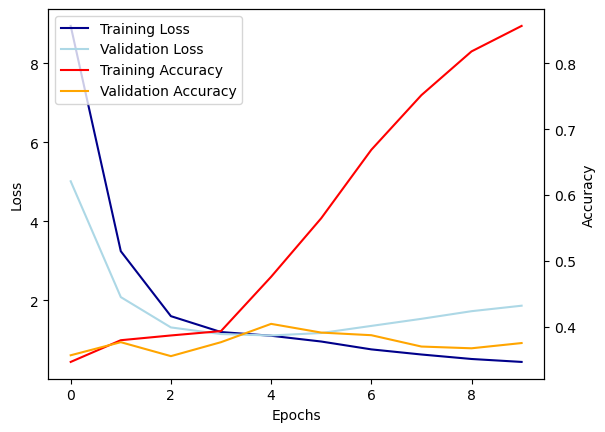

In [55]:
import matplotlib.pyplot as plt

# Get the training and validation metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='lightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot the training and validation accuracy curves
plt.twinx()  # Create a second y-axis that shares the same x-axis
plt.plot(train_acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylabel('Accuracy')

handles, labels = [], []
for ax in plt.gcf().axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels)

plt.show()

24/24 [==============================] - 2s 23ms/step


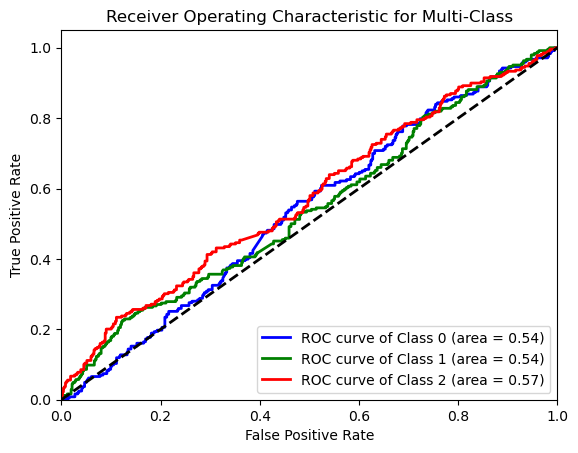

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_onehot = label_binarize(y_train, classes=[0, 1, 2])
y_val_onehot = label_binarize(y_val, classes=[0, 1, 2])
y_pred_proba = model.predict(X_val_pad)
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves in the same plot with different colors
plt.figure()
colors = ['blue', 'green', 'red']
class_labels = ['Class 0', 'Class 1', 'Class 2']
lw = 2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

